In [324]:
# Importing the libraries

# General DS libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import collections

# Machine Learning analysis libraries
from sklearn.ensemble import RandomForestClassifier


In [325]:
# Load stored DataFrame from data wrangling
%store -r recent_nyc2

Which columns have missing values? See below:

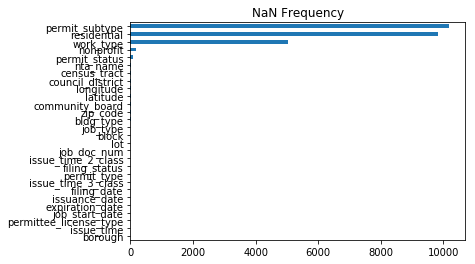

In [326]:
_ = pd.Series(recent_nyc2.isnull().sum()).sort_values(ascending=True).plot.barh(width=0.5)
_ = plt.title('NaN Frequency')
plt.show()

Let's focus on the permit_subtype feature, which has ~45% NaNs.

In [327]:
# Test missing values and populated inputs series
permit_subtype = recent_nyc2.loc[:, ['permit_subtype', 'issue_time_2_class']]
print('Total: ',len(permit_subtype))
permit_subtype_missing = permit_subtype.loc[permit_subtype.permit_subtype.isnull()]
permit_subtype_filled = permit_subtype.loc[permit_subtype.permit_subtype.notnull()]
print('Nulls: ', len(permit_subtype_missing))
print('Filled: ', len(permit_subtype_filled))
print('Total: ',len(permit_subtype_missing) + len(permit_subtype_filled))

Total:  22435
Nulls:  10190
Filled:  12245
Total:  22435


Create a new dataframe with permit_subtype feature and the associated dependent variable, issue time (binary output)

In [328]:
permit_subtype.head()

,permit_subtype,issue_time_2_class
13,OT,1
15,FB,1
16,NaN,1
23,MH,1
25,OT,0


Calculate the log-liklihood of the NaN value. The log-liklihood is the log(# of ones/# of zeros).

In [329]:
# Calculate log-likelihood of input missing values
permit_subtype_missing_LL = np.log(np.sum(permit_subtype_missing.issue_time_2_class==1)/
                                   np.sum(permit_subtype_missing.issue_time_2_class==0))
permit_subtype_missing_LL = {"NaN" :permit_subtype_missing_LL}
permit_subtype_missing_LL

{'NaN': 0.04122271582395431}

Create dummy variables including for the NaNs, totaling in 13 new columns. These are to be used if a categorical variable is desired. 

In [330]:
X = pd.get_dummies(permit_subtype.permit_subtype, dummy_na=True, drop_first=True)
Y = permit_subtype.issue_time_2_class
X = pd.DataFrame(X)
print(permit_subtype.permit_subtype.head())
print(X.head())

13     OT
15     FB
16    NaN
23     MH
25     OT
Name: permit_subtype, dtype: object
    CH  EA  FB  FN  FP  FS  MH  OT  SD  SF  SH  SP  NaN
13   0   0   0   0   0   0   0   1   0   0   0   0    0
15   0   0   1   0   0   0   0   0   0   0   0   0    0
16   0   0   0   0   0   0   0   0   0   0   0   0    1
23   0   0   0   0   0   0   1   0   0   0   0   0    0
25   0   0   0   0   0   0   0   1   0   0   0   0    0


For the continuous variable, calculate the log-liklihood of each category.

In [331]:
# Unique labels 
permit_subtype_unique = permit_subtype_filled.permit_subtype.unique()

# Calculate log-likelihood
permit_subtype_LL = []
for p in permit_subtype_unique:
    ones = permit_subtype_filled[(permit_subtype_filled.permit_subtype == p )&
                                    (permit_subtype_filled.issue_time_2_class == 1)].iloc[:,0].count()
    zeroes = permit_subtype_filled[(permit_subtype_filled.permit_subtype == p)&
                                    (permit_subtype_filled.issue_time_2_class == 0)].iloc[:,0].count()
    log_likelihood = np.log(ones/zeroes)
    permit_subtype_LL.append(log_likelihood)
permit_subtype_pop_LL = dict(zip(permit_subtype_unique, permit_subtype_LL))
permit_subtype_pop_LL

{'BL': 0.15415067982725836,
 'CH': 0.0,
 'EA': 0.05715841383994862,
 'FB': -0.062242308877220896,
 'FN': 0.10145459237666592,
 'FP': -0.29008303398931906,
 'FS': -0.3184537311185346,
 'MH': -0.030620885956328572,
 'OT': -0.2222253748892141,
 'SD': -0.06252035698133393,
 'SF': -0.4723593429381946,
 'SH': -0.395132912870959,
 'SP': 0.052258493668874785}

Add the NaN key value relationship to the dictionary.

In [332]:
log_likelihood_comb = {**permit_subtype_missing_LL,**permit_subtype_pop_LL}
log_likelihood_comb

{'BL': 0.15415067982725836,
 'CH': 0.0,
 'EA': 0.05715841383994862,
 'FB': -0.062242308877220896,
 'FN': 0.10145459237666592,
 'FP': -0.29008303398931906,
 'FS': -0.3184537311185346,
 'MH': -0.030620885956328572,
 'NaN': 0.04122271582395431,
 'OT': -0.2222253748892141,
 'SD': -0.06252035698133393,
 'SF': -0.4723593429381946,
 'SH': -0.395132912870959,
 'SP': 0.052258493668874785}

Test the OT permit type. The value -0.2222253748892141 matches! --> Pass

In [333]:
# Test the OT permit type
ones = permit_subtype_filled[(permit_subtype_filled.permit_subtype == 'OT' )&
                             (permit_subtype_filled.issue_time_2_class == 1)].iloc[:,0].count()
zeroes = permit_subtype_filled[(permit_subtype_filled.permit_subtype == 'OT')&
                             (permit_subtype_filled.issue_time_2_class == 0)].iloc[:,0].count()
log_likelihood = np.log(ones/zeroes)
log_likelihood

# Matches the dictionary value for OT

-0.2222253748892141

Replace original feature with either the (13) categorical features or the (1) continuous variable.

In [334]:
result = pd.DataFrame(permit_subtype.permit_subtype.map(log_likelihood_comb))
result.iloc[:,0]= result.iloc[:,0].fillna(log_likelihood_comb['NaN'])
result = pd.concat([permit_subtype, result, X], axis=1)
result.drop('issue_time_2_class', axis=1)

,permit_subtype,permit_subtype,CH,EA,FB,FN,FP,FS,MH,OT,SD,SF,SH,SP,nan
13,OT,-0.222225,0,0,0,0,0,0,0,1,0,0,0,0,0
15,FB,-0.062242,0,0,1,0,0,0,0,0,0,0,0,0,0
16,NaN,0.041223,0,0,0,0,0,0,0,0,0,0,0,0,1
23,MH,-0.030621,0,0,0,0,0,0,1,0,0,0,0,0,0
25,OT,-0.222225,0,0,0,0,0,0,0,1,0,0,0,0,0
26,FP,-0.290083,0,0,0,0,1,0,0,0,0,0,0,0,0
27,OT,-0.222225,0,0,0,0,0,0,0,1,0,0,0,0,0
28,MH,-0.030621,0,0,0,0,0,0,1,0,0,0,0,0,0
29,OT,-0.222225,0,0,0,0,0,0,0,1,0,0,0,0,0
30,OT,-0.222225,0,0,0,0,0,0,0,1,0,0,0,0,0


The original feature will be deleted and replaced with either the 